# 다음에 볼 영화 예측하기


Movielens 영화 SBR

1) 데이터 확인


$ ls -l ~/data

2) 프로젝트 폴더 생성


$ mkdir -p ~/aiffel/yoochoose

3) 프로젝트 폴더로 데이터 폴더 링크 연결


$ ln -s ~/data/* ~/aiffel/yoochoose/data


이번에도 우리는 Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.



In [1]:
# 모듈 import
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Step 1. 데이터의 전처리
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

### 2.1 Data Load

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

User의 숫자가 6040개,아이템은  3706개가 있다.

In [4]:
# timestamp to datetime
data['Time'] = data['Time'].map(lambda x: datetime.utcfromtimestamp(x))
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


### 2.2 Session Length

In [5]:
#각 유저가 몇 개의 영화를 봤는지 확인
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [6]:
user_length.median(), user_length.mean()


(96.0, 165.5975165562914)

In [7]:
user_length.min(), user_length.max()

(20, 2314)

In [8]:
# User 별 수치 데이터 확인
print(f'median   : {user_length.median()}')
print(f'mean     : {user_length.mean()}' )
print(f'min     : {user_length.min()}' )
print(f'max   : {user_length.max()}')
print(f'quantile : {user_length.quantile(0.999)}')

median   : 96.0
mean     : 165.5975165562914
min     : 20
max   : 2314
quantile : 1343.181000000005


In [9]:
lont_user= user_length[user_length==2314].index[0]

In [10]:
# 각 세션이 몇 개의 클릭 데이터를 갖는지 확인

session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [11]:
# User 별 수치 데이터 확인
print(f'median   : {session_length.median()}')
print(f'mean     : {session_length.mean()}' )
print(f'min     : {session_length.min()}' )
print(f'max   : {session_length.max()}')
print(f'quantile : {session_length.quantile(0.999)}')

median   : 96.0
mean     : 165.5975165562914
min     : 20
max   : 2314
quantile : 1343.181000000005


In [12]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

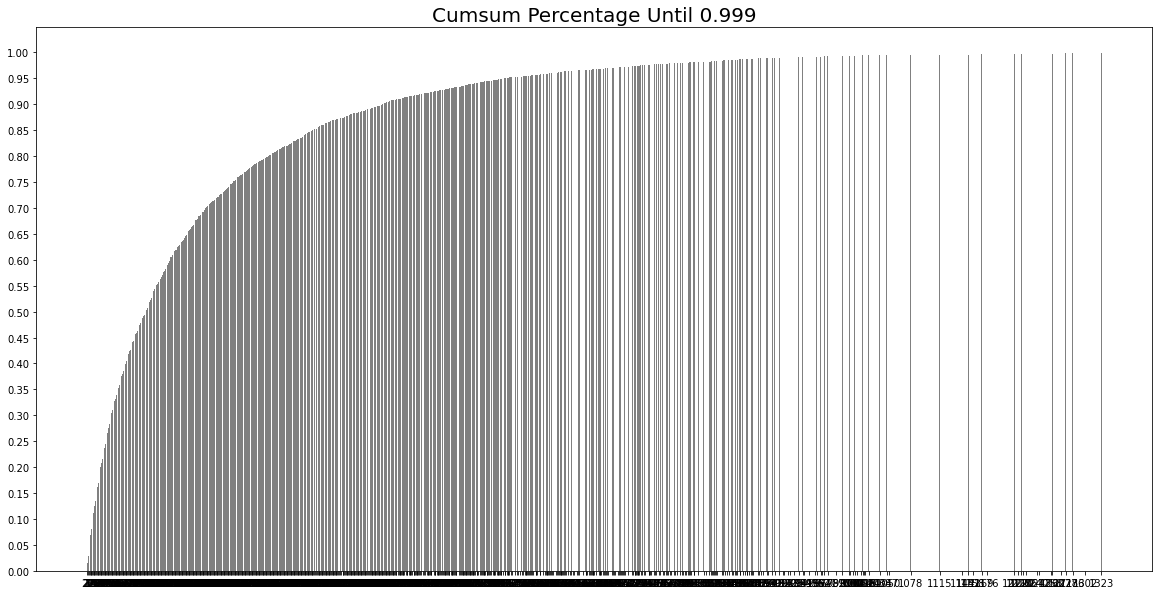

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='grey')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### 2.3 Session Time

In [14]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [15]:
session_length


UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

UserId 별로 묶었을 때 session 수가 그다지 많지 않기 때문에 모든 데이터를 사용하기로 한다.


### 2.4 Data Cleansing

In [16]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [17]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


### 2.5 Train/ Valid/ Test split

In [18]:
# UserId를 기준으로 train, val, test = 0.7, 0.2, 0.1로 분리
tr = data[data['UserId'] <= 4228]
val = data[(data['UserId'] > 4228) & (data['UserId'] <= 5436)]
test = data[data['UserId'] > 5436]

In [19]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 705588
	 Sessions: 4228
	 Items: 3416
	 First Time : 2000-08-03 14:24:25
	 Last Time : 2003-02-28 00:51:39

* valid Set Stats Info
	 Events: 193323
	 Sessions: 1208
	 Items: 3342
	 First Time : 2000-06-03 05:20:31
	 Last Time : 2003-02-28 17:49:50

* test Set Stats Info
	 Events: 100700
	 Sessions: 604
	 Items: 3172
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2003-02-28 13:12:12



In [20]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [21]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# Step 2. 미니 배치의 구성
실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다

### SessionDataset

In [22]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [23]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [24]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 704344, 705565, 705588], dtype=int32)

In [25]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 4225, 4226, 4227])

### SessionDataLoader

In [26]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [27]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [28]:
iter_ex = iter(tr_data_loader)

In [29]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


# Step 3. 모델 구성

이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.



### Evaluation Metric

In [30]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture


In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [32]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

모델에 사용할 hyper-parameter를 class형식으로 관리하겠습니다.

In [33]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=512, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [34]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(512, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(512, 50), (512, 50)]    520200    
_________________________________________________________________
dropout (Dropout)            (512, 50)                 0         
_________________________________________________________________
dense (Dense)                (512, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


# Step 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.


In [35]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [36]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.00977, train_loss=7.37]

	 - Recall@20 epoch 1: 0.094088
	 - MRR@20    epoch 1: 0.022345



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.00781, train_loss=7.42]

	 - Recall@20 epoch 2: 0.199712
	 - MRR@20    epoch 2: 0.049988



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7.46] 

	 - Recall@20 epoch 3: 0.252021
	 - MRR@20    epoch 3: 0.065669



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.0176, train_loss=7.47] 

	 - Recall@20 epoch 4: 0.274985
	 - MRR@20    epoch 4: 0.073058



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.0176, train_loss=7.43] 

	 - Recall@20 epoch 5: 0.287893
	 - MRR@20    epoch 5: 0.077854



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.0137, train_loss=7.44] 

	 - Recall@20 epoch 6: 0.297126
	 - MRR@20    epoch 6: 0.081866



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7.39] 

	 - Recall@20 epoch 7: 0.302067
	 - MRR@20    epoch 7: 0.084421



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.0215, train_loss=7.37] 

	 - Recall@20 epoch 8: 0.306621
	 - MRR@20    epoch 8: 0.086438



Train:   0%|          | 0/1369 [00:00<?, ?it/s, accuracy=0.0195, train_loss=7.34] 

	 - Recall@20 epoch 9: 0.308855
	 - MRR@20    epoch 9: 0.088111



Evaluation:  54%|█████▍    | 202/375 [09:22<08:01,  2.79s/it]

	 - Recall@20 epoch 10: 0.310557
	 - MRR@20    epoch 10: 0.089424



# Step 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.



In [37]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  19%|█▉        | 37/195 [01:42<07:18,  2.77s/it]

	 - Recall@20: 0.309069
	 - MRR@20: 0.090075



- 추론 결과를 확인해보니 Recall@20의 값은 0.309069로, 총 20개의 영화를 추천받았을 때, 그 중에 6개가 선호하는 영화에 포함되어 있다는 의미이다.
- MRR@20의 값(Mean Reciprocal Rank)은 내가 선호하는 영화의 Ranking이 있을 때, 처음으로 추천받은 영화가 얼마나 높은 Ranking의 우선순위를 갖는지 판단하는 값이다.한계가 있으니 여러항목을 비교해야 한다.